In [2]:
# This notebook will contain only some NLP methods such as n-grams because the full notebook was getting too cumbersum

In [1]:
# imports
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
from datetime import datetime

In [3]:
df_lab = pd.read_csv('Lab-Data.csv', index_col=0) # index_col stops index being read as column
df_turk = pd.read_csv('Turk-Data.csv', index_col=0)


C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [4]:
df_lab

,button,event_type,target,time,x,y,step,turkId,file
0,1,mousedown,"[id=""alloc-slider-return-4""]>svg>g>circle",0.000000,397.0,647.0,1,ID1,global_sa_sl_both_2017-02-08 12_48_51.json
1,1,mouseup,"[id=""alloc-slider-return-4""]>svg>g>circle",0.547000,423.0,642.0,1,ID1,global_sa_sl_both_2017-02-08 12_48_51.json
2,1,click,"[id=""alloc-slider-return-4""]>svg>g>circle",0.547000,423.0,642.0,1,ID1,global_sa_sl_both_2017-02-08 12_48_51.json
3,1,mousedown,"[id=""alloc-slider-return-4""]>svg>g>circle",1.176995,426.0,642.0,1,ID1,global_sa_sl_both_2017-02-08 12_48_51.json
4,1,mousedirchange,"[id=""alloc-slider-return-4""]>svg>g>circle",1.790000,440.0,640.0,1,ID1,global_sa_sl_both_2017-02-08 12_48_51.json
...,...,...,...,...,...,...,...,...,...
58280,1,click,"[id=""portfolio-selection""]>div:nth-child(3)>di...",275.048950,942.0,1248.0,1,ID18,study_results.all.json
58281,1,click,"[id=""portfolio-selection""]>div:nth-child(3)>di...",275.048950,942.0,1248.0,2,ID18,study_results.all.json
58282,1,click,"[id=""portfolio-selection""]>div:nth-child(3)>di...",275.048950,942.0,1248.0,3,ID18,study_results.all.json
58283,1,click,"[id=""portfolio-selection""]>div:nth-child(3)>di...",275.048950,942.0,1248.0,4,ID18,study_results.all.json


In [5]:
df_turk['target'].value_counts(), df_lab['target'].value_counts() 

(alloc-slider-2                                                                                                                                                                                                                                                                                 170652
 alloc-slider-5                                                                                                                                                                                                                                                                                 155753
 alloc-slider-4                                                                                                                                                                                                                                                                                 153602
 html > body > main > div#content > form#portfolio-selection > div.investment-test > div.portfolio-interface.row > 

# Renaming Targets

Here I will rename the tagets so that theyre more understandable.
First Idea was to look through each unique html element and try to map it to a more human readable name, but there was way to many.
Looking through the data the items were iterested in are "alloc-slider-X" where X is 1,2,3,4,5.
So it was decided to search for any html elements and rename them to "html other".
To do this any recored containing '>' was renamed.


In [6]:
# Before TURK rename
df_turk['target'].value_counts()

alloc-slider-2                                                                                                                                                                                                                                                                                 170652
alloc-slider-5                                                                                                                                                                                                                                                                                 155753
alloc-slider-4                                                                                                                                                                                                                                                                                 153602
html > body > main > div#content > form#portfolio-selection > div.investment-test > div.portfolio-interface.row > div.

In [7]:
# RENAME TURKS

# Turk target  might be 
# html > body > main > div#content > form#portfolio-selection
# > div.investment-test > div.portfolio-interface.row > div.stock-selection.large-7.columns 
# > div.stock-allocator.row.valign-middle > div.large-4.columns > div#alloc-slider-return-0.sparkline.narrow.return 
# > svg.chart.control > g > circle.handle
# So pick up on the > and rename
df_turk.loc[df_turk['target'].str.contains('>'), 'target'] = 'html_other'

# See how there are many targets not renamed and their distributions
df_turk['target'].value_counts()

html_other               490349
alloc-slider-2           170652
alloc-slider-5           155753
alloc-slider-4           153602
alloc-slider-1           131002
alloc-slider-3           124736
html                      23808
portfolio-selection       15282
investment-results        12167
portfolio-stats            6039
content                    2713
risk-return                1147
alloc-slider-return-3      1040
alloc-slider-return-1       630
saved-port-0                591
alloc-slider-return-2       470
saved-port-1                445
alloc-slider-risk-1         435
alloc-slider-return-0       426
alloc-slider-risk-3         374
alloc-slider-return-4       328
alloc-slider-risk-4         287
alloc-slider-risk-0         245
alloc-slider-risk-2         201
saved-port-2                196
saved-port-3                 86
saved-port-4                 40
saved-port-5                  9
parsley-id-3644               7
saved-port-6                  6
parsley-id-2586               2
parsley-

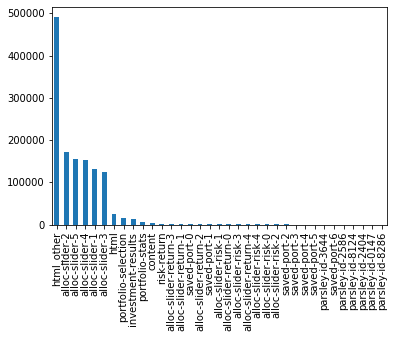

In [8]:
df_turk['target'].value_counts().plot(kind='bar')

In [9]:
# Before LAB rename
df_lab['target'].value_counts()

[id="alloc-slider-return-3"]>svg                                                                            4531
[id="portfolio-selection"]>div:nth-child(1)>div>div:nth-child(1)>div:nth-child(6)>div:nth-child(2)>input    3138
[id="alloc-slider-return-1"]>svg                                                                            2544
[id="alloc-slider-return-4"]>svg                                                                            2399
[id="alloc-slider-return-2"]>svg                                                                            2294
                                                                                                            ... 
[id="investment-results"]>table>tbody                                                                          1
[id="portfolio-stats"]>svg>g>g:nth-child(2)>g:nth-child(1)>text                                                1
[id="portfolio-selection"]>div:nth-child(3)>div>div:nth-child(1)>div:nth-child(4)               

In [10]:
# RENAME LABS

# TODO Labs seem to have many more "html_other" elements than TURK. 
# Might have to rename some of the items to make them more even.

# lab target  might be 
# [id="alloc-slider-risk-4"]>svg

# So pick up on the > and rename
df_lab.loc[df_lab['target'].str.contains('>'), 'target'] = 'html_other'

df_lab.to_csv('lab-Data-renamed.csv')   # save changes

# See how there are many targets not renamed and their distributions
df_lab['target'].value_counts()

html_other               49438
alloc-slider-2            2002
alloc-slider-3            1170
alloc-slider-5             902
alloc-slider-4             788
alloc-slider-1             708
portfolio-selection        622
html                       524
alloc-slider-return-3      436
investment-results         258
alloc-slider-risk-1        233
risk-return                175
alloc-slider-return-2      165
alloc-slider-return-0      136
alloc-slider-risk-3        123
alloc-slider-return-1      103
alloc-slider-risk-0        101
saved-port-0                75
survey-container            71
saved-port-1                60
alloc-slider-risk-2         52
content                     41
alloc-slider-risk-4         35
alloc-slider-return-4       29
pretest3                    12
pretest2                     8
pretest4                     6
pretest1                     5
parsley-id-137               4
saved-port-6                 3
Name: target, dtype: int64

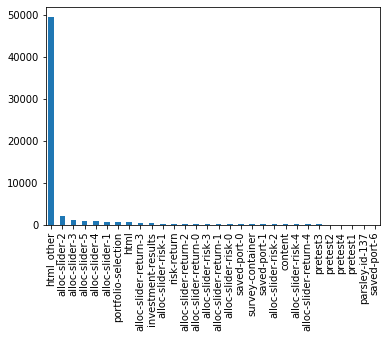

In [11]:
# Comparing this plot for lab values compared to the turk values we can see that html other has a much higher proportion of the targets.
# If we look at the value counts before renaming we can see that the most frequent item is [id="alloc-slider-return-3"]>svg.
# I will rename html elements like [id="alloc-slider-return-3"]>svg to alloc-slider-3.
# Goal is to make the distributions of values for the 2 categories look more similar.
# Other analysis for this project so far has shown that the lab and turk datas cannot be easily identified with number of mouse events,
# therefore I would expect the distribution of sliders to look very similar.

df_lab['target'].value_counts().plot(kind='bar')

In [12]:
# Rename LAB data 
# rename some html elemets to alloc-slider-X

# Reload df_lab as original unaltered data
df_lab = pd.read_csv('Lab-Data.csv', index_col=0)

# Indexs for html elements start at 0.
# alloc-sliders do not.
df_lab.loc[df_lab['target'].str.contains('alloc-slider-return-0'), 'target'] = 'alloc-slider-1'
df_lab.loc[df_lab['target'].str.contains('alloc-slider-return-1'), 'target'] = 'alloc-slider-2'
df_lab.loc[df_lab['target'].str.contains('alloc-slider-return-2'), 'target'] = 'alloc-slider-3'
df_lab.loc[df_lab['target'].str.contains('alloc-slider-return-3'), 'target'] = 'alloc-slider-4'
df_lab.loc[df_lab['target'].str.contains('alloc-slider-return-4'), 'target'] = 'alloc-slider-5'

df_lab.loc[df_lab['target'].str.contains('alloc-slider-risk-0'), 'target'] = 'alloc-slider-1'
df_lab.loc[df_lab['target'].str.contains('alloc-slider-risk-1'), 'target'] = 'alloc-slider-2'
df_lab.loc[df_lab['target'].str.contains('alloc-slider-risk-2'), 'target'] = 'alloc-slider-3'
df_lab.loc[df_lab['target'].str.contains('alloc-slider-risk-3'), 'target'] = 'alloc-slider-4'
df_lab.loc[df_lab['target'].str.contains('alloc-slider-risk-4'), 'target'] = 'alloc-slider-5'

# Now sliders are renamed we can deal with the other html elements

df_lab.loc[df_lab['target'].str.contains('>'), 'target'] = 'html'

# Also remove some of the other nosensical data such as pretest3 and parsley-id-137
df_lab.loc[df_lab['target'].str.contains('pretest'), 'target'] = 'html'
df_lab.loc[df_lab['target'].str.contains('port'), 'target'] = 'html'
df_lab.loc[df_lab['target'].str.contains('parsley'), 'target'] = 'html'
df_lab.loc[df_lab['target'].str.contains('survey-container'), 'target'] = 'html'

# Other elements could be kept, but lets remove them as that will make it simplier and theyre not that frequent anyway
df_lab.loc[df_lab['target'].str.contains('investment-results'), 'target'] = 'html'
df_lab.loc[df_lab['target'].str.contains('risk-return'), 'target'] = 'html'
df_lab.loc[df_lab['target'].str.contains('content'), 'target'] = 'html'


df_lab['target'].value_counts()

html              19189
alloc-slider-4     9395
alloc-slider-2     8547
alloc-slider-3     7854
alloc-slider-5     7261
alloc-slider-1     6039
Name: target, dtype: int64

In [13]:
# Remove duplicates
lab_dups = len(df_lab)-len(df_lab.drop_duplicates())
print(f'Number of duplicate items in lab data: {lab_dups}')
print(f'Percentage duplicate: {lab_dups / len(df_lab) * 100}')

df_lab = df_lab.drop_duplicates()
df_lab['target'].value_counts()

Number of duplicate items in lab data: 11139
Percentage duplicate: 19.111263618426698


html              15796
alloc-slider-4     7116
alloc-slider-2     6952
alloc-slider-3     6324
alloc-slider-5     5892
alloc-slider-1     5066
Name: target, dtype: int64

In [14]:
# Remove any turkId's that havent used all of the sliders in their target history.
# If they havent used all the sliders then their data isnt valid and so it can be removed to clean up the data.

users_with_all_targets = df_lab[df_lab['target'] == "alloc-slider-5"] ['turkId'].unique() # No 9, 10, 11
print( len(users_with_all_targets) )  
all_users = df_lab['turkId'].unique()
print(len(all_users))

#https://www.geeksforgeeks.org/python-difference-two-lists/
users_missing_values = list(set(all_users) - set(users_with_all_targets))
print(users_missing_values)

for ID in users_missing_values:
    df_lab = df_lab[df_lab['turkId'] != ID] 

print(len(df_lab['turkId'].unique() ))

14
18
['ID16', 'ID10', 'ID11', 'ID9']
14


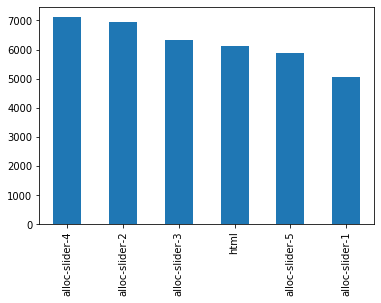

In [15]:
df_lab['target'].value_counts().plot(kind = 'bar')

In [16]:
# See if we can improve on the turk data by renaming more targets

# Rename turk data 
# rename some html elemets to alloc-slider-X

# Reload df_turk as original unaltered data
df_turk = pd.read_csv('turk-Data.csv', index_col=0)

df_turk.loc[df_turk['target'].str.contains('alloc-slider-return-0'), 'target'] = 'alloc-slider-1'
df_turk.loc[df_turk['target'].str.contains('alloc-slider-return-1'), 'target'] = 'alloc-slider-2'
df_turk.loc[df_turk['target'].str.contains('alloc-slider-return-2'), 'target'] = 'alloc-slider-3'
df_turk.loc[df_turk['target'].str.contains('alloc-slider-return-3'), 'target'] = 'alloc-slider-4'
df_turk.loc[df_turk['target'].str.contains('alloc-slider-return-4'), 'target'] = 'alloc-slider-5'

df_turk.loc[df_turk['target'].str.contains('alloc-slider-risk-0'), 'target'] = 'alloc-slider-1'
df_turk.loc[df_turk['target'].str.contains('alloc-slider-risk-1'), 'target'] = 'alloc-slider-2'
df_turk.loc[df_turk['target'].str.contains('alloc-slider-risk-2'), 'target'] = 'alloc-slider-3'
df_turk.loc[df_turk['target'].str.contains('alloc-slider-risk-3'), 'target'] = 'alloc-slider-4'
df_turk.loc[df_turk['target'].str.contains('alloc-slider-risk-4'), 'target'] = 'alloc-slider-5'

# Now sliders are renamed we can deal with the other html elements

df_turk.loc[df_turk['target'].str.contains('>'), 'target'] = 'html'

# Also remove some of the other nosensical data such as saved-port-6 and parsley-id-137
df_turk.loc[df_turk['target'].str.contains('port'), 'target'] = 'html'
df_turk.loc[df_turk['target'].str.contains('parsley'), 'target'] = 'html'
df_turk.loc[df_turk['target'].str.contains('portfolio-stats'), 'target'] = 'html'

# Other elements could be kept, but lets remove them as that will make it simplier and theyre not that frequent anyway
df_turk.loc[df_turk['target'].str.contains('investment-results'), 'target'] = 'html'
df_turk.loc[df_turk['target'].str.contains('risk-return'), 'target'] = 'html'
df_turk.loc[df_turk['target'].str.contains('content'), 'target'] = 'html'

df_turk['target'].value_counts()

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


html              469722
alloc-slider-2    190130
alloc-slider-5    177458
alloc-slider-4    169760
alloc-slider-1    143466
alloc-slider-3    142537
Name: target, dtype: int64

In [17]:
# Remove duplicates
turk_dups = len(df_turk)-len(df_turk.drop_duplicates())
print(f'Number of duplicate items in Turk data: {turk_dups}')
print(f'Percentage duplicate: {turk_dups / len(df_turk) * 100}')

df_turk = df_turk.drop_duplicates()
df_turk['target'].value_counts()

Number of duplicate items in Turk data: 319714
Percentage duplicate: 24.725131527763708


html              368643
alloc-slider-2    139265
alloc-slider-5    128444
alloc-slider-4    124034
alloc-slider-1    106968
alloc-slider-3    106005
Name: target, dtype: int64

In [18]:
# Remove Id's with missing values

users_with_all_targets = df_turk[df_turk['target'] == "alloc-slider-5"] ['turkId'].unique() # No 9, 10, 11
print( len(users_with_all_targets) )  
all_users = df_turk['turkId'].unique()
print(len(all_users))

users_missing_values = list(set(all_users) - set(users_with_all_targets))
print(len(users_missing_values))

for ID in users_missing_values:
    df_turk = df_turk[df_turk['turkId'] != ID] 

print(len(df_turk['turkId'].unique() ))

389
461
72
389


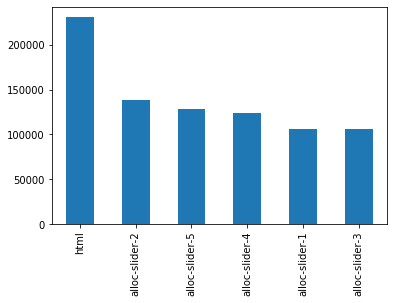

In [19]:
# This plot now looks perfect
# Now the distributions for the lab and turk look very similar, with the most frequent target being approximately half as common as html other.

df_turk['target'].value_counts().plot(kind = 'bar')

In [20]:
# Save the new renamed data
df_turk.to_csv('turk-Data-renamed.csv')
df_lab.to_csv('lab-Data-renamed.csv')

In [21]:
# load them back in.
df_turk = pd.read_csv('turk-Data-renamed.csv', index_col=0)
df_lab = pd.read_csv('lab-Data-renamed.csv', index_col=0)


In [22]:

def calculate_ngrams(dataframe, n):
    # TODO docstring
    # will return a dataframe of ngrams and frequency given n
    # Can take a while to compute
    
    IDs = dataframe['turkId'].unique()
    all_ngrams = []

    for ID in IDs:
        # Get targets of each user
        targets = dataframe[ dataframe['turkId'] == ID ] ['target'].to_numpy()

        ngrams_generator = nltk.ngrams(targets, n)               # creates ngram generator, can be used to find ngrams
        ngrams_distribution = nltk.FreqDist(ngrams_generator)    # nltk distribution. in form ngrams:frequency
        common_ngrams = ngrams_distribution.most_common()       # converts to list

        # append this useres ngrams to all ngrams
        # extend rather than append to iterate over list and not add a list of items as a single item.
        all_ngrams.extend(common_ngrams)

    # Convert list to dataframe
    df_ngrams = pd.DataFrame(all_ngrams, columns =['n-grams', 'Frequency'])
    df_ngrams = df_ngrams.astype(dtype= {"n-grams":"object", "Frequency":"int64"})

    # Change n-grams series from list of tuples to list of strings  # https://stackoverflow.com/questions/59993097/how-can-i-join-tuples-to-strings-in-a-pandas-dataframe
    df_ngrams['n-grams'] = df_ngrams['n-grams'].agg(' : '.join)

    # Sum the frequencies of similar ngrams.
    df_ngrams = df_ngrams.groupby(['n-grams']).sum().reset_index().sort_values(by='Frequency', ascending=False)

    # 'Normalise' the frequencies to compare lab and turk.
    # frequency of ngram divided by number of users
    df_ngrams['Relative Frequency'] = df_ngrams['Frequency'].divide(len(IDs))
    return df_ngrams.reset_index(drop=True)

# NOTE: This wont take into account outliers. 
# Say if noone touched slider 2 other than 1 user, we would still say slider 2 was very frequent event if it was only 1 user.



In [23]:
lab_unigrams = calculate_ngrams(df_lab, 1)
print(lab_unigrams.head())
turk_unigrams = calculate_ngrams(df_turk, 1)
print(turk_unigrams.head())


n-grams  Frequency  Relative Frequency
0  alloc-slider-4       7116          508.285714
1  alloc-slider-2       6952          496.571429
2  alloc-slider-3       6324          451.714286
3            html       6114          436.714286
4  alloc-slider-5       5892          420.857143
          n-grams  Frequency  Relative Frequency
0            html     230665          592.969152
1  alloc-slider-2     138228          355.341902
2  alloc-slider-5     128444          330.190231
3  alloc-slider-4     123305          316.979434
4  alloc-slider-1     106405          273.534704


In [24]:
lab_unigrams['n-grams'][1]

'alloc-slider-2'

In [25]:
turk_unigrams['n-grams'][1] == lab_unigrams['n-grams'][1]

True

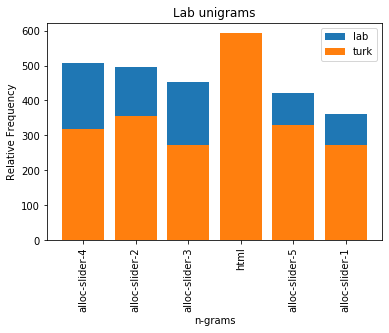

In [26]:
plt.bar(lab_unigrams['n-grams'].head(10), lab_unigrams['Relative Frequency'].head(10), label='lab')
plt.bar(turk_unigrams['n-grams'].head(10), turk_unigrams['Relative Frequency'].head(10), label='turk')

labels = df_lab['target'].value_counts()[:20]    # Get first 20 most frequent items
labels = labels.index.to_list()   # items to list


#plt.xticks((labels))
#plt.xticks(('html_other', 'alloc-slider-2', 'alloc-slider-3'))
plt.xlabel("n-grams")
plt.xticks(rotation=90)
plt.ylabel("Relative Frequency")
plt.title("Lab unigrams")
plt.legend(loc='best')

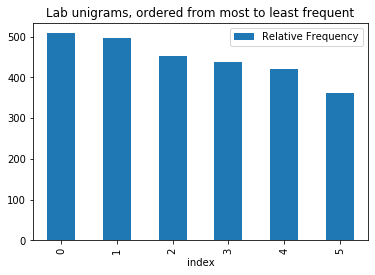

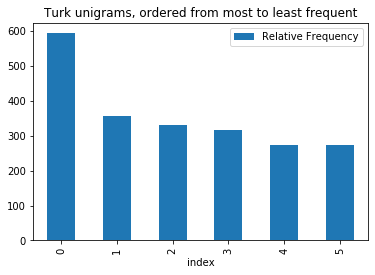

In [27]:
# These plots show the frequency of different unique n-grams in Lab and Turk data.
# I can see that anything after the 10th most frequent item contains almost no occurances so it can be removed.

lab_unigrams.reset_index().plot.bar(x='index', y='Relative Frequency', title='Lab unigrams, ordered from most to least frequent')
turk_unigrams.reset_index().plot.bar(x='index', y='Relative Frequency', title='Turk unigrams, ordered from most to least frequent')

,n-grams,Frequency,Relative Frequency
0,alloc-slider-4,7116,508.285714
1,alloc-slider-2,6952,496.571429
2,alloc-slider-3,6324,451.714286
3,html,6114,436.714286
4,alloc-slider-5,5892,420.857143
5,alloc-slider-1,5066,361.857143


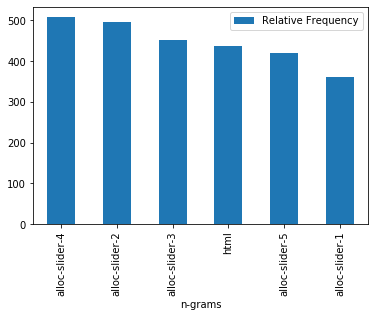

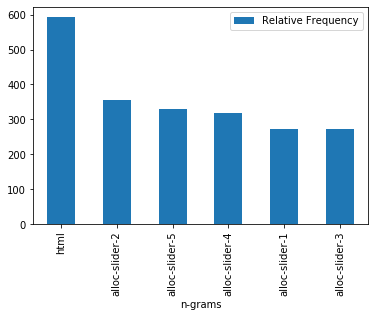

In [28]:
lab_unigrams.head(10).plot.bar(x='n-grams', y='Relative Frequency')
turk_unigrams.head(10).plot.bar(x='n-grams', y='Relative Frequency')

# Create these plots but with a breakdown in each column showing what ID it came from.
# This will help us identidy any outliers, and remove them if they are skewing the resutls.
# TODO create a stacked bar chart in tableau by adding column to n-grams dataframe of ID.

lab_unigrams

Now we've done some exploration into unigrams, lets look at tri-grams to see if theres anything interesting going on.


In [29]:
lab_trigrams = calculate_ngrams(df_lab, 3)
turk_trigrams = calculate_ngrams(df_turk, 3)

print(lab_trigrams.head())
print(turk_trigrams.head())

n-grams  Frequency  \
0  alloc-slider-4 : alloc-slider-4 : alloc-slider-4       6600   
1  alloc-slider-2 : alloc-slider-2 : alloc-slider-2       6413   
2  alloc-slider-3 : alloc-slider-3 : alloc-slider-3       5781   
3                                html : html : html       5482   
4  alloc-slider-5 : alloc-slider-5 : alloc-slider-5       5430   

   Relative Frequency  
0          471.428571  
1          458.071429  
2          412.928571  
3          391.571429  
4          387.857143  
                                            n-grams  Frequency  \
0                                html : html : html     209679   
1  alloc-slider-2 : alloc-slider-2 : alloc-slider-2     126184   
2  alloc-slider-5 : alloc-slider-5 : alloc-slider-5     118599   
3  alloc-slider-4 : alloc-slider-4 : alloc-slider-4     111837   
4  alloc-slider-1 : alloc-slider-1 : alloc-slider-1      97891   

   Relative Frequency  
0          539.020566  
1          324.380463  
2          304.881748  
3         

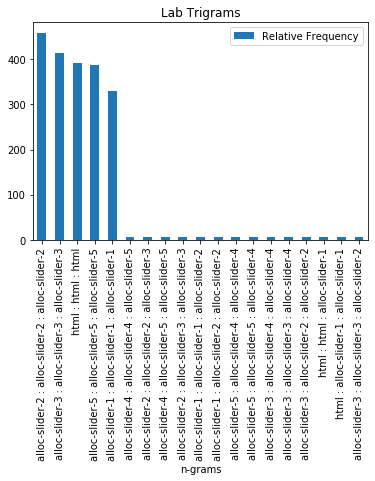

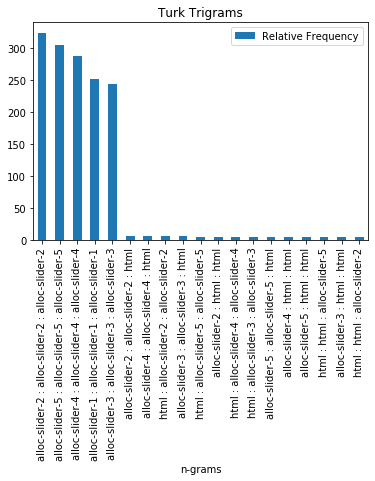

In [30]:
#[1:20] hides the first result which is much more frequent and hides everything else
lab_trigrams[1:20].plot.bar(x='n-grams', y='Relative Frequency', title='Lab Trigrams')
turk_trigrams[1:20].plot.bar(x='n-grams', y='Relative Frequency', title='Turk Trigrams')

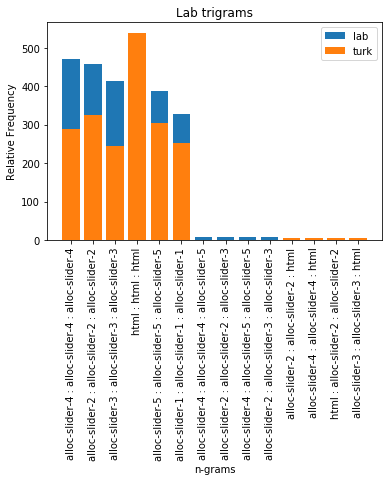

In [31]:
plt.bar(lab_trigrams['n-grams'].head(10), lab_trigrams['Relative Frequency'].head(10), label='lab')
plt.bar(turk_trigrams['n-grams'].head(10), turk_trigrams['Relative Frequency'].head(10), label='turk')

#plt.xticks((labels))
#plt.xticks(('html_other', 'alloc-slider-2', 'alloc-slider-3'))
plt.xlabel("n-grams")
plt.xticks(rotation=90)
plt.ylabel("Relative Frequency")
plt.title("Lab trigrams")
plt.legend(loc='best')

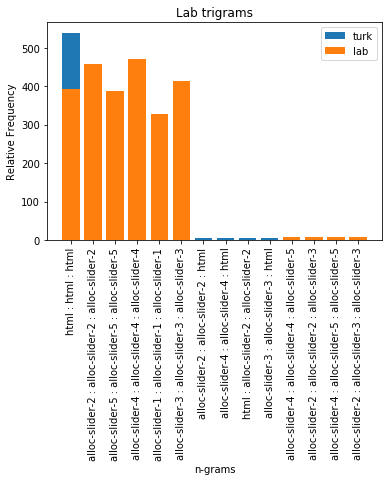

In [32]:
plt.bar(turk_trigrams['n-grams'].head(10), turk_trigrams['Relative Frequency'].head(10), label='turk')
plt.bar(lab_trigrams['n-grams'].head(10), lab_trigrams['Relative Frequency'].head(10), label='lab')


#plt.xticks((labels))
#plt.xticks(('html_other', 'alloc-slider-2', 'alloc-slider-3'))
plt.xlabel("n-grams")
plt.xticks(rotation=90)
plt.ylabel("Relative Frequency")
plt.title("Lab trigrams")
plt.legend(loc='best')

In [33]:
turk_trigrams

,n-grams,Frequency,Relative Frequency
0,html : html : html,209679,539.020566
1,alloc-slider-2 : alloc-slider-2 : alloc-slider-2,126184,324.380463
2,alloc-slider-5 : alloc-slider-5 : alloc-slider-5,118599,304.881748
3,alloc-slider-4 : alloc-slider-4 : alloc-slider-4,111837,287.498715
4,alloc-slider-1 : alloc-slider-1 : alloc-slider-1,97891,251.647815
...,...,...,...
179,alloc-slider-3 : alloc-slider-2 : alloc-slider-4,1,0.002571
180,alloc-slider-5 : alloc-slider-1 : alloc-slider-2,1,0.002571
181,alloc-slider-4 : alloc-slider-2 : alloc-slider-4,1,0.002571
182,html : alloc-slider-2 : alloc-slider-4,1,0.002571


Maybe bi-grams will be better to use

n-grams  Frequency  Relative Frequency
0  alloc-slider-4 : alloc-slider-4       6853          489.500000
1  alloc-slider-2 : alloc-slider-2       6671          476.500000
2  alloc-slider-3 : alloc-slider-3       6046          431.857143
3                      html : html       5768          412.000000
4  alloc-slider-5 : alloc-slider-5       5655          403.928571
                           n-grams  Frequency  Relative Frequency
0                      html : html     219156          563.383033
1  alloc-slider-2 : alloc-slider-2     132053          339.467866
2  alloc-slider-5 : alloc-slider-5     123384          317.182519
3  alloc-slider-4 : alloc-slider-4     117396          301.789203
4  alloc-slider-1 : alloc-slider-1     102081          262.419023


,n-grams,Frequency,Relative Frequency
0,html : html,219156,563.383033
1,alloc-slider-2 : alloc-slider-2,132053,339.467866
2,alloc-slider-5 : alloc-slider-5,123384,317.182519
3,alloc-slider-4 : alloc-slider-4,117396,301.789203
4,alloc-slider-1 : alloc-slider-1,102081,262.419023
5,alloc-slider-3 : alloc-slider-3,100190,257.557841
6,alloc-slider-2 : html,2538,6.524422
7,alloc-slider-4 : html,2490,6.401028
8,alloc-slider-3 : html,2427,6.239075
9,html : alloc-slider-2,2415,6.208226


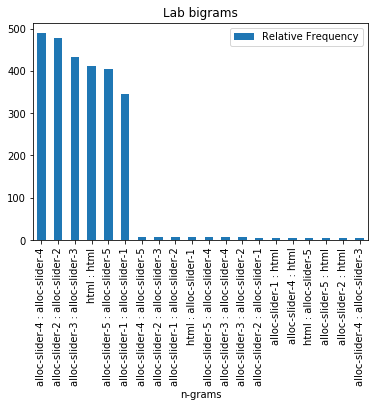

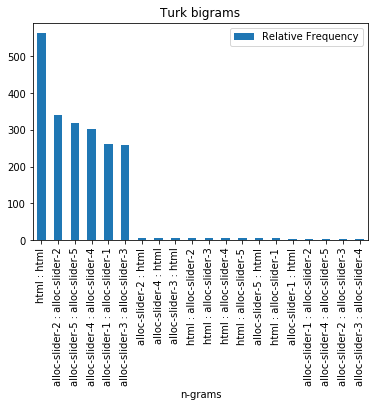

In [34]:
lab_bigrams = calculate_ngrams(df_lab, 2)
turk_bigrams = calculate_ngrams(df_turk, 2)

print(lab_bigrams.head())
print(turk_bigrams.head())

lab_bigrams.head(20).plot.bar(x='n-grams', y='Relative Frequency', title='Lab bigrams')
turk_bigrams.head(20).plot.bar(x='n-grams', y='Relative Frequency', title='Turk bigrams')

turk_bigrams

(<matplotlib.axes._subplots.AxesSubplot at 0x1b6335bf488>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1b633e49208>)

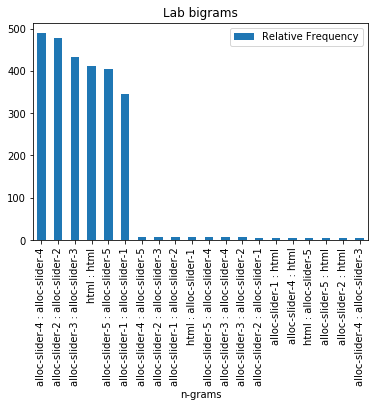

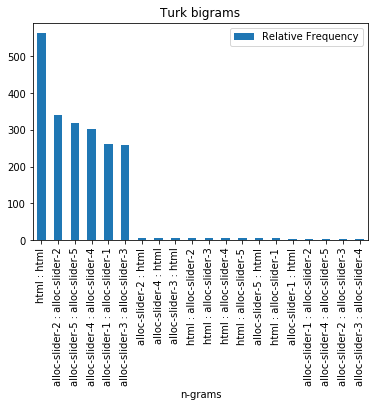

In [35]:
lab_bigrams.head(20).plot.bar(x='n-grams', y='Relative Frequency', title='Lab bigrams'),turk_bigrams.head(20).plot.bar(x='n-grams', y='Relative Frequency', title='Turk bigrams')

# New idea

Now we know what the average turk and lab data distribution looks like for unigrams, bigrams, and trigrams.
Next I need to make a function that will return the count of each different gram for EACH INDIVIDUAL.
Then I can compare the counts of these people the counts of the average.

TODO: Do a scatterplot where the x-axis is the the different ngrams and the y axis is count of ngrams for each individual. Each users datapoint will be a different colour x.

After this maybe try with different ngrams being different axis or something.

In [36]:
def calculate_users_ngrams(dataframe, n):
    # TODO docstring
    # will return a dataframe of ngrams and frequency given n
    # Can take a while to compute
    
    IDs = dataframe['turkId'].unique()
    all_users_ngram_counts = []
    all_users_ID = []

    for ID in IDs:
        # Get targets of each user
        targets = dataframe[ dataframe['turkId'] == ID ] ['target'].to_numpy()

        ngrams_generator = nltk.ngrams(targets, n)               # creates ngram generator, can be used to find ngrams
        ngrams_distribution = nltk.FreqDist(ngrams_generator)    # nltk distribution. in form ngrams:frequency
        common_ngrams = ngrams_distribution.most_common()       # converts to list

        all_users_ngram_counts.extend(common_ngrams)

        # TODO Change so we append everything as a list and then turn everything into a dataframe outside the loop to massively improve effecienncy

        # Add users ID as a new column
        ID_column = [ID] * len(common_ngrams)
        all_users_ID.extend(ID_column)

    #print(len(all_users_ngram_counts[0][5]))

    # Convert list to dataframe
    df_ngrams = pd.DataFrame(all_users_ngram_counts, columns =['n-grams', 'Frequency'])
    df_ngrams = df_ngrams.astype(dtype= {"n-grams":"object", "Frequency":"int64"})
    df_ngrams['n-grams'] = df_ngrams['n-grams'].agg(' : '.join)

    # 'Normalise' the frequencies to compare lab and turk.
    # frequency of ngram divided by number of users

    # Add ID column
    df_ngrams['turkId'] = all_users_ID

    return df_ngrams

lab_users_unigrams = calculate_users_ngrams(df_lab, 1)
turk_users_unigrams = calculate_users_ngrams(df_turk, 1)

In [37]:
lab_users_unigrams

,n-grams,Frequency,turkId
0,alloc-slider-3,682,ID1
1,alloc-slider-1,650,ID1
2,alloc-slider-2,570,ID1
3,alloc-slider-5,521,ID1
4,alloc-slider-4,235,ID1
...,...,...,...
79,alloc-slider-3,428,ID18
80,alloc-slider-5,349,ID18
81,alloc-slider-4,311,ID18
82,alloc-slider-1,308,ID18


In [38]:
from mpl_toolkits.mplot3d import Axes3D

Text(0.5, 0, 'alloc-slider-3')

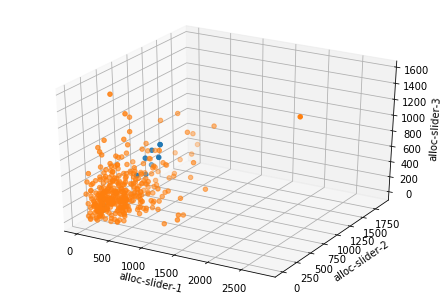

In [39]:
ax = Axes3D(plt.figure())

ax.scatter(lab_users_unigrams [lab_users_unigrams['n-grams'] == 'alloc-slider-1'] ['Frequency'] ,
    lab_users_unigrams [lab_users_unigrams['n-grams'] == 'alloc-slider-2'] ['Frequency'] , 
    lab_users_unigrams [lab_users_unigrams['n-grams'] == 'alloc-slider-3'] ['Frequency'])


ax.scatter(turk_users_unigrams [turk_users_unigrams['n-grams'] == 'alloc-slider-1'] ['Frequency'].head(380) ,
    turk_users_unigrams [turk_users_unigrams['n-grams'] == 'alloc-slider-2'] ['Frequency'].head(380) , 
    turk_users_unigrams [turk_users_unigrams['n-grams'] == 'alloc-slider-3'] ['Frequency'].head(380))

ax.set_xlabel('alloc-slider-1')
ax.set_ylabel('alloc-slider-2')
ax.set_zlabel('alloc-slider-3')

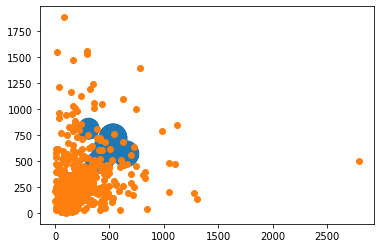

In [40]:
plt.scatter( 
    lab_users_unigrams [lab_users_unigrams['n-grams'] == 'alloc-slider-1'] ['Frequency'] ,
    lab_users_unigrams [lab_users_unigrams['n-grams'] == 'alloc-slider-2'] ['Frequency'] , 
    lab_users_unigrams [lab_users_unigrams['n-grams'] == 'alloc-slider-3'] ['Frequency'] )

plt.scatter( 
    turk_users_unigrams [turk_users_unigrams['n-grams'] == 'alloc-slider-1'] ['Frequency'].head(380) , 
    turk_users_unigrams [turk_users_unigrams['n-grams'] == 'alloc-slider-2'] ['Frequency'].head(380) )


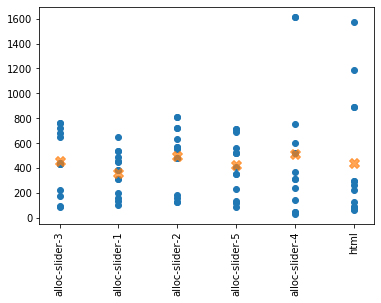

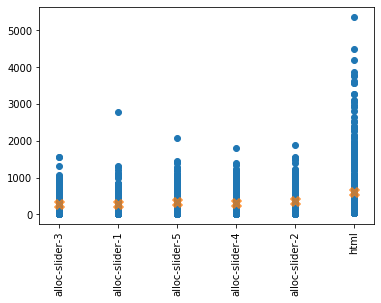

In [41]:
plt.scatter(lab_users_unigrams['n-grams'], lab_users_unigrams['Frequency'] )
plt.scatter(lab_unigrams['n-grams'], lab_unigrams['Relative Frequency'], marker='X', s=100, alpha=0.7 )
plt.xticks(rotation=90)
plt.show()

plt.scatter(turk_users_unigrams['n-grams'], turk_users_unigrams['Frequency'] )
plt.scatter(turk_unigrams['n-grams'], turk_unigrams['Relative Frequency'], marker='X', s=100, alpha=0.7 )
plt.xticks(rotation=90)
plt.show()

In [42]:
lab_users_bigrams = calculate_users_ngrams(df_lab, 2)
turk_users_bigrams = calculate_users_ngrams(df_turk, 2)

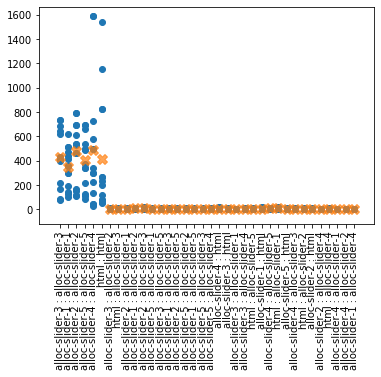

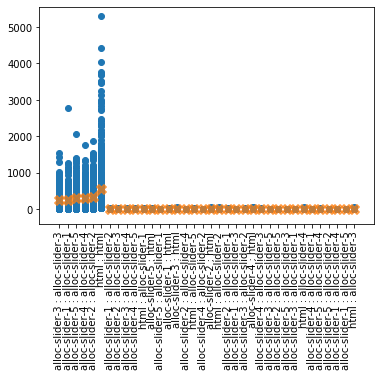

In [43]:

plt.scatter(lab_users_bigrams['n-grams'], lab_users_bigrams['Frequency'] )
plt.scatter(lab_bigrams['n-grams'], lab_bigrams['Relative Frequency'], marker='X', s=100, alpha=0.7 )
plt.xticks(rotation=90)
plt.show()

plt.scatter(turk_users_bigrams['n-grams'], turk_users_bigrams['Frequency'] )
plt.scatter(turk_bigrams['n-grams'], turk_bigrams['Relative Frequency'], marker='X', s=100, alpha=0.7 )
plt.xticks(rotation=90)
plt.show()

In [44]:
# TODO: Plot the 'average' values for the distribution of these points on the same chart.


# Here they suggest bayes filtering can be used to detect language, maybe I use too?
https://stackoverflow.com/questions/101569/algorithm-to-detect-similar-documents-in-python-script

# Naive Bayes
Another idea from SPAM detection is using a naive bayes, here they get the count of each word for each email and bayes it.
Could even use this to get the counts of 2/3-grams to compare?
https://towardsdatascience.com/spam-filtering-using-naive-bayes-98a341224038

TODO: I think for any of these to be used we would have to properly rename all the mouse items so they match

In [45]:
# Another idea from SPAM detection is using a naive bayes, here they get the count of each word for each email and bayes it.
# Could even use this to get the counts of 2/3-grams to compare?
# https://towardsdatascience.com/spam-filtering-using-naive-bayes-98a341224038

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score



In [46]:
# Converts a pandas datafram of targets to a list of strings
def targets_to_string(dataframe):
    IDs = dataframe['turkId'].unique()
    targets_text = []

    for ID in IDs:
        targets_series = dataframe[ dataframe['turkId'] == ID ] ['target']
        targets =  ', '.join(targets_series)
        targets_text.append( targets)
        #targets_text = targets

    return targets_text

turk_targets = targets_to_string(df_turk)
lab_targets = targets_to_string(df_lab)
turk_labels = np.zeros( len(turk_targets) )
lab_labels = np.ones( len(lab_targets) )


In [47]:
# Append targets and labels
X = np.append(turk_targets, lab_targets)

y = np.append(turk_labels, lab_labels)

In [48]:
len(lab_targets)

14

In [49]:
# Test train split


X_train, X_test, y_train, y_test = train_test_split(X, y)

In [50]:
#Explore CountVecotrizer

vectorizer = CountVectorizer() 
counts = vectorizer.fit_transform(X_train)
p = counts.toarray()

In [51]:
p   # This is wrong, there should be 6 columns, 5 for each slider and 1 html other

array([[1424,  450, 1424],
       [2132,  120, 2132],
       [4471,  213, 4471],
       [ 572,   46,  572],
       [1181,   51, 1181],
       [2567, 3269, 2567],
       [ 510,  849,  510],
       [1382, 3561, 1382],
       [1438,  131, 1438],
       [ 508,   35,  508],
       [1403, 2005, 1403],
       [ 999,  147,  999],
       [1076,  915, 1076],
       [1763,  132, 1763],
       [1231,   88, 1231],
       [ 436,   57,  436],
       [2615, 3055, 2615],
       [ 905,   72,  905],
       [1847,  861, 1847],
       [2537, 2511, 2537],
       [6244,  231, 6244],
       [1363,   74, 1363],
       [1748,   54, 1748],
       [1290,   77, 1290],
       [1340,   44, 1340],
       [ 438,  138,  438],
       [1855,   76, 1855],
       [1588,   43, 1588],
       [2658,  222, 2658],
       [1078,   50, 1078],
       [1504, 1413, 1504],
       [ 275,  164,  275],
       [3461, 1251, 3461],
       [1213,   76, 1213],
       [ 849,   78,  849],
       [1388, 2383, 1388],
       [ 231,   62,  231],
 

In [52]:
# Instantiating Multinomial Naive Bayes Classifier
classifier = MultinomialNB()
targets = y_train
classifier.fit(counts, targets)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [53]:
example_count = vectorizer.transform(X_test)
predictions = classifier.predict(example_count)
predictions

array([1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
       1., 1., 1., 1., 0., 0., 1., 1., 0., 1., 1., 0., 0., 1., 1., 0., 0.,
       1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0.,
       1., 1., 1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 0., 1., 1.,
       0., 0., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1.,
       0., 1., 1., 1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 0.])

In [54]:
from sklearn.metrics import accuracy_score

print( accuracy_score(y_test, predictions) )

from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions)



0.36633663366336633


array([[34, 64],
       [ 0,  3]], dtype=int64)

Accuracy score: 0.3465346534653465
F1 score: 0.2785714285714286
[[33 65]
 [ 1  2]]


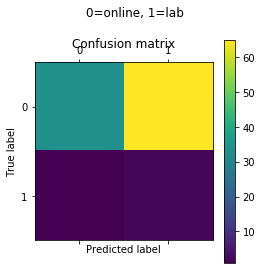

In [82]:

print( f'Accuracy score: {accuracy_score(y_test, predictions)}' )
f1 = f1_score(y_test, predictions, average='macro')
print( f'F1 score: {f1}' )

# High accuracy because of imbalenced classes 
# https://machinelearningmastery.com/failure-of-accuracy-for-imbalanced-class-distributions/
# This website has some nice references about imblaenced class distributions. TODO: use in diss.
# data sampling – customized algorithms– cost sensitive algorithms– one class algorithms – threshold moving – probability calibration


# https://machinelearningmastery.com/tour-of-evaluation-metrics-for-imbalanced-classification/
# Better ways of dealing with imbalenced data

cm = confusion_matrix(y_test, predictions)
print(cm)

plt.matshow(cm)
plt.title('Confusion matrix')
plt.suptitle('0=online, 1=lab')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [83]:
# Above has too much online data so there are uneven classes.
# Look at only the first X (20 or so) online data for training

#X_train, X_test, y_train, y_test = train_test_split(X, y)

# TODO: make classes balenced

lab_length = len(lab_targets)

X_balanced = np.append( turk_targets[ :lab_length ] , lab_targets)

y_balanced = np.append(turk_labels[ :lab_length ], lab_labels)

print(f'Length of lab and turk data: {len(X_balanced)}')

X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced)

vectorizer = CountVectorizer() 
counts = vectorizer.fit_transform(X_train)

classifier = MultinomialNB()
targets = y_train
classifier.fit(counts, targets)

example_count = vectorizer.transform(X_test)
predictions = classifier.predict(example_count)

print( f'Accuracy score: {accuracy_score(y_test, predictions)}' )
f1 = f1_score(y_test, predictions, average='macro')
print( f'F1 score: {f1}' )
cm = confusion_matrix(y_test, predictions)
print(cm)


Length of lab and turk data: 28
Accuracy score: 0.2857142857142857
F1 score: 0.22222222222222224
[[0 5]
 [0 2]]


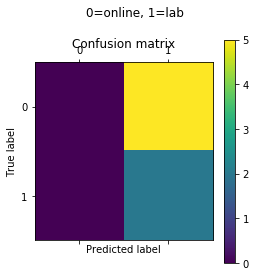

In [84]:
plt.matshow(cm)
plt.title('Confusion matrix')
plt.suptitle('0=online, 1=lab')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Accuracy score: 0.5714285714285714
F1 score: 0.5714285714285715
[[2 3]
 [0 2]]


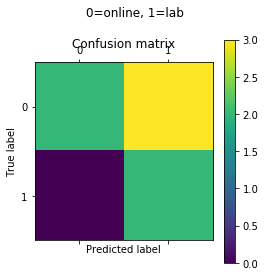

In [85]:
# Try a different method of Spam classification
# https://towardsdatascience.com/spam-detection-with-logistic-regression-23e3709e522


from sklearn.linear_model import LogisticRegression

######################
# Even class sizes

Spam_model = LogisticRegression(solver='liblinear', penalty='l1')
Spam_model.fit(counts, y_train)

example_count = vectorizer.transform(X_test)
pred = Spam_model.predict(example_count)
print( f'Accuracy score: {accuracy_score(y_test,pred)}' )
f1 = f1_score(y_test, pred, average='macro')
print( f'F1 score: {f1}' )
# Accuracy of 0.66% not the best but also not bad.
# TODO: Run this on bi/tri-grams data to see if that will be better.
# Instead of having a matrix of the differnt words, have matrix of different ngrams.

cm = confusion_matrix(y_test, pred)
print(cm)
plt.matshow(cm)
plt.title('Confusion matrix')
plt.suptitle('0=online, 1=lab')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


Accuracy score: 0.9702970297029703
F1 score: 0.4924623115577889
[[98  0]
 [ 3  0]]


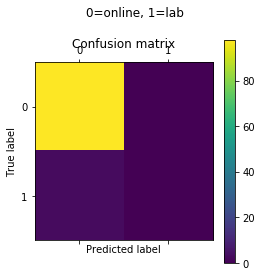

In [86]:
# Try Logistical regression with unbalanced classes.
#https://machinelearningmastery.com/what-is-imbalanced-classification/

# X, y are still the full dataset.
X_train, X_test, y_train, y_test = train_test_split(X, y)

vectorizer = CountVectorizer() 
counts = vectorizer.fit_transform(X_train)

Spam_model = LogisticRegression(solver='liblinear', penalty='l1')
Spam_model.fit(counts, y_train)

example_count = vectorizer.transform(X_test)
pred = Spam_model.predict(example_count)
print( f'Accuracy score: {accuracy_score(y_test,pred)}' )
f1 = f1_score(y_test, pred, average='macro')
print( f'F1 score: {f1}' )
# Accuracy of 0.66% not the best but also not bad.
# TODO: Run this on bi/tri-grams data to see if that will be better.
# Instead of having a matrix of the differnt words, have matrix of different ngrams.

cm = confusion_matrix(y_test, pred)
print(cm)
plt.matshow(cm)
plt.title('Confusion matrix')
plt.suptitle('0=online, 1=lab')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# N-Gram data rather than target count data

The algorithms used above are just using the mouse target variables to varying success.
Try similar approaches to the balanced methods, but use bi/tri-gram data rather than just none/unigrams.



In [87]:
# TODO get a list of bi grams for each user.
# Turns out the Count Vectorizer has an ngram feature :/

# First do with unbalanced classes, then balanced.
X_train, X_test, y_train, y_test = train_test_split(X, y)

vectorizer_ngram = CountVectorizer(analyzer='word', ngram_range=(2, 2))
ngram_counts = vectorizer_ngram.fit_transform(X_train)
print(vectorizer_ngram.get_feature_names()) # Not sure if this worked correclty, lets try anyway lol.

X_test = vectorizer_ngram.transform(X_test) # TODO: SHould be treating alloc-slider-1/alloc-slider-2 as different n-grams.


['alloc slider', 'html alloc', 'html html', 'slider alloc', 'slider html']


Accuracy score: 0.9504950495049505
F1 score: 0.4873096446700507
[[96  0]
 [ 5  0]]


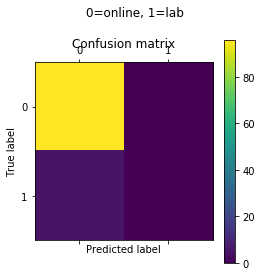

In [88]:

Spam_model = LogisticRegression(solver='liblinear', penalty='l1')
Spam_model.fit(ngram_counts, y_train)

pred = Spam_model.predict(X_test)
print( f'Accuracy score: {accuracy_score(y_test, pred)}' )
f1 = f1_score(y_test, pred, average='macro')
print( f'F1 score: {f1}' )
# Accuracy of 0.96 on unbalanced data

cm = confusion_matrix(y_test, pred)
print(cm)
plt.matshow(cm)
plt.title('Confusion matrix')
plt.suptitle('0=online, 1=lab')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

['alloc slider', 'html alloc', 'html html', 'slider alloc', 'slider html']

Accuracy score: 0.42857142857142855
F1 score: 0.41666666666666663
Train data matrix: 
 [[9 1]
 [3 8]]
Test data matrix: 
 [[1 3]
 [1 2]]


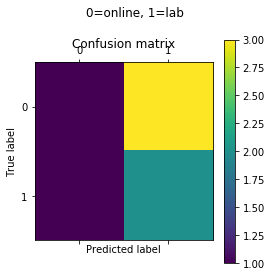

In [95]:
# Try with n-grams and balanced data.

X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced)

vectorizer_ngram = CountVectorizer(analyzer='word', ngram_range=(2, 2))
ngram_counts = vectorizer_ngram.fit_transform(X_train)
print(vectorizer_ngram.get_feature_names()) # Not sure if this worked correclty, lets try anyway lol.

X_test = vectorizer_ngram.transform(X_test)

Spam_model = LogisticRegression(solver='liblinear', penalty='l1')
Spam_model.fit(ngram_counts, y_train)

pred = Spam_model.predict(X_test)
print( f'\nAccuracy score: {accuracy_score(y_test, pred)}' )
f1 = f1_score(y_test, pred, average='macro')
print( f'F1 score: {f1}' )
# Accuracy of 0.777 on balanced data
# Prety good, I imagine if this was working proberly itd be even better


cm = confusion_matrix(y_train, Spam_model.predict(ngram_counts))
print('Train data matrix: \n', cm)
cm = confusion_matrix(y_test, pred)
print('Test data matrix: \n', cm)

plt.matshow(cm)
plt.title('Confusion matrix')
plt.suptitle('0=online, 1=lab')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


# Try HMM

Not entirely sure how these work but will word it out as I go along.


https://towardsdatascience.com/hidden-markov-models-for-time-series-classification-basic-overview-a59b74e5e65b
    Normally towardsdatascience is really good but this makes no sense to me at all.

Some guys github repository using HMM for binary sentimental analysis of tweets - https://github.com/FantacherJOY/Hidden-Markov-Model-for-NLP


"In the case one label is way more frequent than the other (say Class B appears for every 100 samples of Class A), or in the case one category is broader than the other (have more variance, i.e. Class A is an expected behavior of a process and Class B is all the cases that are abnormal), then we might want to train a unique HMM for Class A. For each new sample, we compute the likelihood to the model, and if it falls below a pre-defined threshold (that can be chosen with respect to some validation sample, or in the worst case, from the training samples themselves) we assign this sample to Class B. If the likelihood is above the threshold, we assign the sample to Class A." - https://datascience.stackexchange.com/questions/8560/can-hmm-be-used-as-a-binary-classifier

In [0]:
# TODO remove Duplicate data earlier to improve effeciency.
df_lab
print(f'Number of duplicate items in Lab data: {len(df_lab)-len(df_lab.drop_duplicates())}')
print(f'Number of duplicate items in Turk data: {len(df_turk)-len(df_turk.drop_duplicates())}')

In [0]:
# First get the targets data in a time series of time, target, and ID.

# When we remove the mouse event we have much more duplicate data.
# Drop this data and reset the indexes to account for missing values.
# Since there was a correlation between time and number of mouse events maybe I can use index to substitue for time.
df_markov = df_lab[['target', 'time', 'turkId']].drop_duplicates().reset_index(drop=True)
df_markov

In [0]:
len(df_markov)-len(df_markov.drop_duplicates())

In [0]:
#TODO: https://medium.com/@a.ydobon/justforfunpython-n-gram-to-quantify-similarity-between-sentences-2d61e68a478c
# Use this method to compare one users targets with the rest of their class to get a similarity.
# Then can get the average similarity compared to the group of each target.
# Then compare similarity to other group e.g. how similar is this turk to a lab person.
# If any turk matches lab more then we boldly assume it belongs in the wrong class.

# This funciton works perfectly, its the other function that doesnt work properly lol.
def lists_similarity(list_a, list_b):
    # Calculates siilarity of list_a to list_b
    # Given 2 lists of ngrams, return how 'similar' lists are
    # Similarity is number of matching items / length of list a
    
    similar_count = 0
    common=[]

    for item_a in list_a:
        for item_b in list_b:
            if item_a == item_b:
                #print('MATCH')
                similar_count += 1
                common.append(item_a)


    #print('similar_count', similar_count)
    #print('len(list_a)', len(list_a))
    #print('len(list_b)', len(list_b))
    similarity = similar_count/len(list_a)
    return similarity#,common
    

In [0]:
# Look into similarity matrixes Tom seems to think theyre the same thing.

def compare_all(dataframe, n):
    IDs = dataframe['turkId'].unique()

    # First get a list of all the ngrams for each user in the dataframe
    users_ngrams_list = []

    for ID in IDs:
        targets = dataframe[ dataframe['turkId'] == ID ] ['target'].to_numpy()

        ngrams_generator = nltk.ngrams(targets, n)  # creates ngram generator, can be used to find ngrams
        ngrams_list = list(ngrams_generator)        # generator to list
        
        users_ngrams_list.append(ngrams_list)

    #users_ngrams_list # this is a list of lists. index 0 has a list of ngrams from the first user ID.


    # FIrst enumerates, a and b are essesnally a list of the unique users that we go through.
    # After that loop we index into the list, which contains a list of the ngrams of the user with that index
    # e.g. index 0 stores the ngrams about the first user at IDs[0]

    resutls = []    # results should end up being same length as num of IDs

    for index_a, ngrams_list_a in enumerate(users_ngrams_list):
        print(f'ID:{index_a} out of {len(users_ngrams_list)}')

        now = datetime.now()
        current_time = now.strftime("%H:%M:%S")
        print("Current Time =", current_time)

        total_similarity = 0
        for index_b, ngrams_list_b in enumerate(users_ngrams_list):
            # compare list index_a's ngrams with list index_b's

            # we dont want to compare a list to itself for similarity
            if index_a != index_b:
                total_similarity += lists_similarity(ngrams_list_a, ngrams_list_b)

        #print('total_similarity', total_similarity)
        similarity_average = total_similarity/len(IDs)
        #print(f'{index_a} average similarity : {similarity_average}')
        resutls.append(similarity_average)

        #print('similarity_average', similarity_average)

    return pd.DataFrame( {'ID': IDs, 'Similarity': resutls} )

lab_sim = compare_all(df_lab, 2)
#turk_sim = compare_all(df_turk, 2) # start time 15:36

In [0]:
turk_sim = compare_all(df_turk, 2) # start time 20:37

In [0]:
lab_sim

In [0]:
turk_sim.to_csv('turk_sim.csv') # Save as this took AGES to run
turk_sim.plot(kind='bar')